In [20]:
from numba import jit
import numpy as np
import copy

@jit(nopython=True)
def bb_intersection_over_union(A, B) -> float:
    xA = max(A[0], B[0])
    yA = max(A[1], B[1])
    xB = min(A[2], B[2])
    yB = min(A[3], B[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    if interArea == 0:
        return 0.0

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (A[2] - A[0]) * (A[3] - A[1])
    boxBArea = (B[2] - B[0]) * (B[3] - B[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# TODO:
# support named_box
def union(boxes, iou_thr=None):
    """
    Implementation of greedy union

    boxes:
        list of box, box in (xmin, ymin, xmax, ymax)
    """
    if iou_thr is None:
        f = intersects()
    else:
        f = intersects_over_threshold(iou_thr)
    boxes = copy.deepcopy(boxes)
    i = 0
    while i < len(boxes):
        j = i+1
        while j < len(boxes):
            if f(boxes[i], boxes[j]) and i != j:
                boxes[i] = union_merge(boxes[i], boxes[j])
                boxes.pop(j)
                if i > j:
                    i -= 1
                j = -1 # -1 + 1 = 0
            j += 1
        i += 1
    return boxes

def union_merge(box1, box2):
    return (min(box1[0],box2[0]), min(box1[1],box2[1]), max(box1[2],box2[2]), max(box1[3],box2[3]))

class intersects():
    """
    box1 and box2:
        (xmin, ymin, xmax, ymax)
        
    Separating Axis Theorem:
        https://stackoverflow.com/a/40795835/11671779
    """
    def __call__(self, box1, box2):
        return not (box1[2] < box2[0] or box1[0] > box2[2] or box1[1] > box2[3] or box1[3] < box2[1])

class intersects_over_threshold():
    def __init__(self, iou_thr):
        self.iou_thr = iou_thr
    
    def __call__(self, box1, box2):
        iou = bb_intersection_over_union(box1, box2)
        return iou > self.iou_thr

In [64]:
from numba import jit
import numpy as np
import copy

import warnings

@jit(nopython=True)
def bb_intersection_over_union(A, B) -> float:
    xA = max(A[0], B[0])
    yA = max(A[1], B[1])
    xB = min(A[2], B[2])
    yB = min(A[3], B[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    if interArea == 0:
        return 0.0

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (A[2] - A[0]) * (A[3] - A[1])
    boxBArea = (B[2] - B[0]) * (B[3] - B[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def prefilter_boxes(boxes, scores, labels, weights, thr):
    # Create dict with boxes stored by its label
    new_boxes = dict()

    for t in range(len(boxes)):

        if len(boxes[t]) != len(scores[t]):
            print('Error. Length of boxes arrays not equal to length of scores array: {} != {}'.format(len(boxes[t]), len(scores[t])))
            exit()

        if len(boxes[t]) != len(labels[t]):
            print('Error. Length of boxes arrays not equal to length of labels array: {} != {}'.format(len(boxes[t]), len(labels[t])))
            exit()

        for j in range(len(boxes[t])):
            score = scores[t][j]
            if score < thr:
                continue
            label = int(labels[t][j])
            box_part = boxes[t][j]
            x1 = float(box_part[0])
            y1 = float(box_part[1])
            x2 = float(box_part[2])
            y2 = float(box_part[3])

            # Box data checks
            if x2 < x1:
                warnings.warn('X2 < X1 value in box. Swap them.')
                x1, x2 = x2, x1
            if y2 < y1:
                warnings.warn('Y2 < Y1 value in box. Swap them.')
                y1, y2 = y2, y1
            if x1 < 0:
                warnings.warn('X1 < 0 in box. Set it to 0.')
                x1 = 0
            if x1 > 1:
                warnings.warn('X1 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                x1 = 1
            if x2 < 0:
                warnings.warn('X2 < 0 in box. Set it to 0.')
                x2 = 0
            if x2 > 1:
                warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                x2 = 1
            if y1 < 0:
                warnings.warn('Y1 < 0 in box. Set it to 0.')
                y1 = 0
            if y1 > 1:
                warnings.warn('Y1 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                y1 = 1
            if y2 < 0:
                warnings.warn('Y2 < 0 in box. Set it to 0.')
                y2 = 0
            if y2 > 1:
                warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                y2 = 1
            if (x2 - x1) * (y2 - y1) == 0.0:
                warnings.warn("Zero area box skipped: {}.".format(box_part))
                continue

            # [label, score, weight, model index, x1, y1, x2, y2]
            b = [int(label), float(score) * weights[t], weights[t], t, x1, y1, x2, y2]
            if label not in new_boxes:
                new_boxes[label] = []
            new_boxes[label].append(b)

    # Sort each list in dict by score and transform it to numpy array
    for k in new_boxes:
        current_boxes = np.array(new_boxes[k])
        new_boxes[k] = current_boxes[current_boxes[:, 1].argsort()[::-1]]

    return new_boxes

# TODO:
# support named_box
def union(boxes_list, scores_list, labels_list, weights=None, iou_thr=0.55, skip_box_thr=0.0):
    if weights is None:
        weights = [1] * len(boxes_list)
    filtered_boxes = prefilter_boxes(boxes_list, scores_list, labels_list, weights, skip_box_thr)
    final_box = []
    final_scores = []
    final_labels = []
    for label in filtered_boxes:
        boxes = filtered_boxes[label][:,4:].tolist()
        scores = filtered_boxes[label][:,1].tolist()
        boxes, scores = greedy_union(boxes, scores=scores, iou_thr=iou_thr, inplace=False)
        final_box.extend(boxes)
        final_scores.extend(scores)
        final_labels.extend([label]*len(final_box))
    return final_box, final_scores, np.array(final_labels)

def greedy_union(boxes, scores=None, iou_thr=None, inplace=False,):
    """
    Implementation of greedy union

    boxes:
        list of box, box in (xmin, ymin, xmax, ymax)
    """
    if iou_thr is None:
        f = intersects()
    else:
        f = intersects_over_threshold(iou_thr)
    if not inplace:
        boxes = copy.deepcopy(boxes)
    i = 0
    while i < len(boxes):
        j = i+1
        while j < len(boxes):
            if f(boxes[i], boxes[j]) and i != j:
                if scores is not None:
                    scores[i] = max(scores[i], scores[j])
                    scores.pop(j)
                boxes[i] = union_merge(boxes[i], boxes[j])
                boxes.pop(j)
                if i > j:
                    i -= 1
                j = -1 # -1 + 1 = 0
            j += 1
        i += 1
    return boxes, scores

def union_merge(box1, box2):
    return (min(box1[0],box2[0]), min(box1[1],box2[1]), max(box1[2],box2[2]), max(box1[3],box2[3]))

class intersects():
    """
    box1 and box2:
        (xmin, ymin, xmax, ymax)
        
    Separating Axis Theorem:
        https://stackoverflow.com/a/40795835/11671779
    """
    def __call__(self, box1, box2):
        return not (box1[2] < box2[0] or box1[0] > box2[2] or box1[1] > box2[3] or box1[3] < box2[1])

class intersects_over_threshold():
    def __init__(self, iou_thr):
        self.iou_thr = iou_thr
    
    def __call__(self, box1, box2):
        iou = bb_intersection_over_union(box1, box2)
        return iou > self.iou_thr

In [65]:
boxes_list = [[
    [0.00, 0.51, 0.81, 0.91],
    [0.10, 0.31, 0.71, 0.61],
    [0.01, 0.32, 0.83, 0.93],
    [0.02, 0.53, 0.11, 0.94],
    [0.03, 0.24, 0.12, 0.35],
],[
    [0.04, 0.56, 0.84, 0.92],
    [0.12, 0.33, 0.72, 0.64],
    [0.38, 0.66, 0.79, 0.95],
    [0.08, 0.49, 0.21, 0.89],
]]
scores_list = [[0.9, 0.8, 0.2, 0.4, 0.7], [0.5, 0.8, 0.7, 0.3]]
labels_list = [[0, 1, 0, 1, 1], [1, 1, 1, 0]]
weights = [2, 1]

boxes_list_flat = [i_ for i in boxes_list for i_ in i]
scores_list_flat = [i_ for i in scores_list for i_ in i]
labels_list_flat = [i_ for i in labels_list for i_ in i]

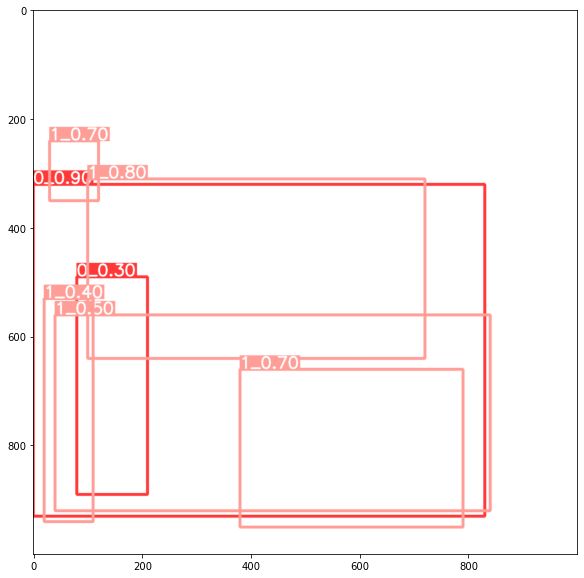

In [67]:
boxes, scores, labels = union(boxes_list, scores_list, labels_list, weights=None, iou_thr=0.55, skip_box_thr=0.0)
im_union = make_image_box(boxes, names=labels.astype(np.int32), scores=scores)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
# ax.xaxis.set_ticks_position('top')
ax.imshow(im_union)
plt.show()

In [71]:
bb_intersection_over_union(boxes_list_flat[2], boxes_list_flat[8])

0.10395841663334665

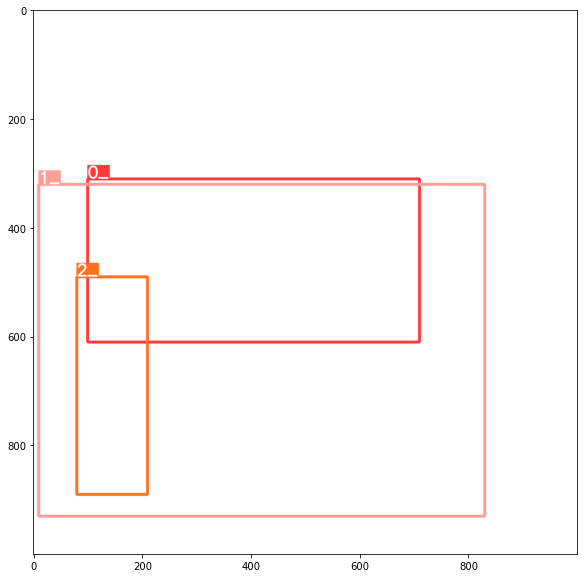

In [70]:
im_ori = make_image_box([boxes_list_flat[1], boxes_list_flat[2], boxes_list_flat[8]])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
# ax.xaxis.set_ticks_position('top')
ax.imshow(im_ori)
plt.show()

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ensemble_boxes import *

class Colors:
    """
    https://github.com/ultralytics/yolov5/blob/master/utils/plots.py
    """
    # Ultralytics color palette https://ultralytics.com/
    def __init__(self):
        # hex = matplotlib.colors.TABLEAU_COLORS.values()
        hex = ('FF3838', 'FF9D97', 'FF701F', 'FFB21D', 'CFD231', '48F90A', '92CC17', '3DDB86', '1A9334', '00D4BB',
               '2C99A8', '00C2FF', '344593', '6473FF', '0018EC', '8438FF', '520085', 'CB38FF', 'FF95C8', 'FF37C7')
        self.palette = [self.hex2rgb('#' + c) for c in hex]
        self.n = len(self.palette)

    def __call__(self, i, bgr=False):
        c = self.palette[int(i) % self.n]
        return (c[2], c[1], c[0]) if bgr else c

    @staticmethod
    def hex2rgb(h):  # rgb order (PIL)
        return tuple(int(h[1 + i:1 + i + 2], 16) for i in (0, 2, 4))

colors = Colors()

class Annotator:
    """
    https://github.com/ultralytics/yolov5/blob/master/utils/plots.py
    """
    # YOLOv5 Annotator for train/val mosaics and jpgs and detect/hub inference annotations
    def __init__(self, im, line_width=None, font_size=None, font='Arial.ttf', pil=False, example='abc'):
        assert im.data.contiguous, 'Image not contiguous. Apply np.ascontiguousarray(im) to Annotator() input images.'
        self.im = im
        self.lw = line_width or max(round(sum(im.shape) / 2 * 0.003), 2)  # line width

    def box_label(self, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
        p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
        cv2.rectangle(self.im, p1, p2, color, thickness=self.lw, lineType=cv2.LINE_AA)
        if label:
            tf = max(self.lw - 1, 1)  # font thickness
            w, h = cv2.getTextSize(label, 0, fontScale=self.lw / 3, thickness=tf)[0]  # text width, height
            outside = p1[1] - h - 3 >= 0  # label fits outside box
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(self.im, p1, p2, color, -1, cv2.LINE_AA)  # filled
            cv2.putText(self.im, label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2), 0, self.lw / 3, txt_color,
                        thickness=tf, lineType=cv2.LINE_AA)

    def rectangle(self, xy, fill=None, outline=None, width=1):
        # Add rectangle to image (PIL-only)
        self.draw.rectangle(xy, fill, outline, width)

    def text(self, xy, text, txt_color=(255, 255, 255)):
        # Add text to image (PIL-only)
        w, h = self.font.getsize(text)  # text width, height
        self.draw.text((xy[0], xy[1] - h + 1), text, fill=txt_color, font=self.font)

    def result(self):
        # Return annotated image as array
        return np.asarray(self.im)
    
def show_boxes(boxes, names=None, name_to_id=None, scores=None, img_size=(1000,1000), denormalized_box=True):
    im = make_image_box(boxes, names=names, name_to_id=name_to_id, scores=scores)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.xaxis.set_ticks_position('top')
    ax.imshow(im)
    plt.show()

def make_image_box(boxes, names=None, name_to_id=None, scores=None, img_size=(1000,1000), denormalized_box=True):
    im = np.ones((img_size[0],img_size[1],3),dtype='uint8')*255
    annotator = Annotator(im)
    if denormalized_box:
        boxes = np.array(boxes) * min(img_size)
        boxes = boxes.astype(np.int32).tolist()
    if names is None:
        names = range(len(boxes))
    if name_to_id is None:
        name_to_id = {v:k for k, v in enumerate(set(names))}
    if scores is None:
        scores = [''] * len(boxes)
    else:
        scores = ["{:.2f}".format(score) for score in scores]
    for box, name, score in zip(boxes, names, scores):
        annotator.box_label(box, str(name) + '_' + score, color=colors(name_to_id[name]))
    return annotator.im

True